In [14]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

train_images = np.load('quickdraw_subset_np/train_images.npy')
train_labels = np.load('quickdraw_subset_np/train_labels.npy')
test_images = np.load('quickdraw_subset_np/test_images.npy')
test_labels = np.load('quickdraw_subset_np/test_labels.npy')

train_images = train_images[(train_labels==0) | (train_labels==2)]
train_labels = train_labels[(train_labels==0) | (train_labels==2)]
test_images = test_images[(test_labels==0) | (test_labels==2)]
test_labels = test_labels[(test_labels==0) | (test_labels==2)]

train_labels[train_labels == 0] = -1
train_labels[train_labels == 2] = 1
test_labels[test_labels == 0] = -1
test_labels[test_labels == 2] = 1
train_flat = train_images.reshape(train_images.shape[0], -1)
test_flat = test_images.reshape(test_images.shape[0], -1)
train_labels = train_labels.reshape(train_labels.shape[0], 1)
test_labels = test_labels.reshape(test_labels.shape[0], 1)
# PCA
#https://medium.com/technological-singularity/build-a-principal-component-analysis-pca-algorithm-from-scratch-7515595bf08b


def PCA_from_Scratch(X, n_components):
    X = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-4)
    cov_mat = np.cov(X, rowvar=False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)  # Use eigh for symmetric matrices (covariance is symmetric)
    sort_indices = np.argsort(eigen_values)[::-1]
    principal_components = eigen_vectors[:, sort_indices[:n_components]]

    return principal_components


def transform(X, principal_components):
    X = X.copy()
    return X.dot(principal_components)



# LDA 
#https://www.kaggle.com/code/egazakharenko/linear-discriminant-analysis-lda-from-scratch
class LDA():
  def __init__(self, n_components=None):
     self.n_components = n_components
  def fit(self,X,y):
     self.X = X
     self.y = y
     samples = X.shape[0]
     features= X.shape[1]
     classes, cls_counts = np.unique(y,return_counts=True)
     priors = cls_counts/samples
     X_mean = np.array([X[y==cls].mean(axis=0) for cls in classes])
     betweenCLSdeviation = X_mean - X.mean(axis=0)
     withinCLSdeviation = X - X_mean[y]

     Sb = priors* betweenCLSdeviation.T @ betweenCLSdeviation
     Sw = withinCLSdeviation.T @ withinCLSdeviation / samples
     Sw_inv = np.linalg.pinv(Sw)
     eigvals, eigvecs = np.linalg.eig(Sw_inv @ Sb)
     self.dvecs = eigvecs[:, np.argsort(eigvals)[::-1]]
     self.weights = X_mean @ self.dvecs @ self.dvecs.T
     self.bias = np.log(priors) - 0.5 * np.diag(X_mean @ self.weights.T)
     if self.n_components is None:
        self.n_components = min(classes.size - 1, features)
  def transform(self, X):
    return X @ self.dvecs[:, : self.n_components]

  def predict(self, X_test):
    scores = X_test @ self.weights.T + self.bias
    return np.argmax(scores, axis=1)
  
def score(y_pred, y_true):
        accuracy = np.mean(y_pred == y_true)
        return accuracy

def macroF1(y_pred, y_true):
    labels = np.unique(y_true)
    f1_scores = []

    for label in labels:
        tp = np.sum((y_pred == label) & (y_true == label))
        fp = np.sum((y_pred == label) & (y_true != label))
        fn = np.sum((y_pred != label) & (y_true == label))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        f1_scores.append(f1)
    return np.mean(f1_scores)

In [3]:
train_normal = train_flat/255
test_normal = test_flat/255
pcs = PCA_from_Scratch(train_normal, 128)
train_proj = transform(train_normal, pcs)
test_proj = transform(test_normal, pcs)
train_binary = (train_normal > 0.3).astype(int)
test_binary = (test_normal > 0.3).astype(int)

In [4]:
train_labels = np.expand_dims(train_labels,axis=1)


In [5]:
# https://github.com/DrIanGregory/MachineLearning-SupportVectorMachines/blob/master/supportVectorMachines.py
class SVM(object):
    def __init__(self, kernel='linear', C=0.0, gamma=1.0, degree=3, coef0=1.0):
        self.C = float(C) if C is not None else 0.0
        self.gamma = float(gamma) if gamma is not None else 1.0
        self.degree = int(degree)
        self.kernel = kernel or 'linear'
        self.coef0 = float(coef0) if coef0 is not None else 1.0
    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self, x, y):
        return (np.dot(x, y) + self.coef0) ** self.degree

    def gaussian_kernel(self, x, y):
        return np.exp(-self.gamma * np.linalg.norm(x - y) ** 2)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64).flatten()
        n_samples, n_features = X.shape

        K = np.zeros((n_samples, n_samples), dtype=np.float64)
        for i in range(n_samples):
            for j in range(n_samples):
                if self.kernel == 'linear':
                    K[i, j] = self.linear_kernel(X[i], X[j])
                elif self.kernel == 'gaussian':
                    K[i, j] = self.gaussian_kernel(X[i], X[j])
                elif self.kernel == 'polynomial':
                    K[i, j] = self.polynomial_kernel(X[i], X[j])

        # Set up QP problem
        print(K.shape)
        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        A = matrix(y.reshape(1, -1), tc='d')
        b = matrix(0.0)

        if self.C == 0.0:
            G = matrix(-np.eye(n_samples))
            h = matrix(np.zeros(n_samples))
        else:
            G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
            h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Solver settings
        solvers.options['show_progress'] = True
        solvers.options['abstol'] = 1e-6
        solvers.options['reltol'] = 1e-6
        solvers.options['feastol'] = 1e-6

        # Solve QP
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.ravel(solution['x'])

        # Select support vectors
        sv_mask = alphas > 1e-5
        self.alphas = alphas[sv_mask]
        self.sv = X[sv_mask]
        self.sv_y = y[sv_mask]
        ind = np.arange(len(alphas))[sv_mask]

        # Compute bias term b
        self.b = 0.0
        for n in range(len(self.alphas)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.alphas * self.sv_y * K[ind[n], sv_mask])
        self.b /= len(self.alphas)

        # Linear weights (only for linear kernel)
        if self.kernel == 'linear':
            self.w = np.zeros(n_features, dtype=np.float64)
            for n in range(len(self.alphas)):
                self.w += self.alphas[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        X = np.asarray(X, dtype=np.float64)
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0.0
                for a, sv_y, sv in zip(self.alphas, self.sv_y, self.sv):
                    if self.kernel == 'linear':
                        s += a * sv_y * self.linear_kernel(X[i], sv)
                    elif self.kernel == 'gaussian':
                        s += a * sv_y * self.gaussian_kernel(X[i], sv)
                    elif self.kernel == 'polynomial':
                        s += a * sv_y * self.polynomial_kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))


In [6]:
#   5 fold cross validation

def crossValidation(X, y, k=5):
    from collections import defaultdict

    y = y.flatten()
    label_indices = defaultdict(list)
    for idx, label in enumerate(y):
        label_indices[label].append(idx)

    folds = [[] for _ in range(k)]
    for indices in label_indices.values():
        np.random.shuffle(indices)
        for i, idx in enumerate(indices):
            folds[i % k].append(idx)

    trainsets = []
    for i in range(k):
        idxs = np.array(folds[i])
        trainsets.append((X[idxs], y[idxs]))

    return trainsets


In [ ]:
avg_scores = []
kernels = ['linear']
Cs = [0.1,0.125, 0.15,0.175, 0.2]
train_list = [train_proj, train_normal, train_binary]
test_list = [test_proj, test_normal, test_binary]
test_labels = test_labels.flatten()
PCAlist = [32, 64, 128, 256]
# dataset = [ train_binary]
# testset = [ test_binary]
for i in PCAlist:  
    print("PCA: ", i)
    pcs = PCA_from_Scratch(train_normal, i)
    train_proj = transform(train_normal, pcs)
    test_proj = transform(test_normal, pcs)
    trainsets = crossValidation(train_proj, train_labels)
    for C in Cs:
        scores = []
        for fold_idx in range(5):
            val_X, val_y = trainsets[fold_idx]
            val_y = val_y.flatten()

            train_X = np.vstack([trainsets[j][0] for j in range(5) if j != fold_idx])
            train_y = np.hstack([trainsets[j][1] for j in range(5) if j != fold_idx]).flatten()

            svm = SVM(kernel='linear', C=C)
            svm.fit(train_X, train_y)
            preds = svm.predict(val_X)

            acc = score(preds, val_y)
            print(f"C = {C}, fold = {fold_idx}, Accuracy = {acc:.4f}")
            scores.append(acc)

        avg_score = np.mean(scores)
        avg_scores.append((i, C, avg_score))
        print(f" C: {C}, Avg Acc: {avg_score:.4f}")


PCA:  32
(6400, 6400)
     pcost       dcost       gap    pres   dres
 0: -1.1813e+03 -1.6787e+03  8e+04  3e+01  7e-12
 1: -1.9332e+02 -1.5829e+03  5e+03  2e+00  6e-12
 2: -1.3462e+02 -8.4790e+02  1e+03  2e-01  2e-12
 3: -1.1593e+02 -3.2607e+02  3e+02  6e-02  1e-12
 4: -1.1915e+02 -1.7657e+02  7e+01  1e-02  9e-13
 5: -1.2434e+02 -1.5464e+02  4e+01  5e-03  9e-13
 6: -1.2733e+02 -1.4510e+02  2e+01  3e-03  9e-13
 7: -1.2882e+02 -1.4082e+02  1e+01  2e-03  9e-13
 8: -1.3019e+02 -1.3696e+02  7e+00  7e-04  9e-13
 9: -1.3099e+02 -1.3487e+02  4e+00  2e-04  9e-13
10: -1.3165e+02 -1.3383e+02  2e+00  1e-04  9e-13
11: -1.3206e+02 -1.3315e+02  1e+00  3e-05  1e-12
12: -1.3232e+02 -1.3281e+02  5e-01  1e-05  1e-12
13: -1.3244e+02 -1.3267e+02  2e-01  4e-06  9e-13
14: -1.3250e+02 -1.3259e+02  8e-02  6e-07  1e-12
15: -1.3252e+02 -1.3256e+02  4e-02  6e-08  1e-12
16: -1.3254e+02 -1.3255e+02  8e-03  3e-09  1e-12
17: -1.3254e+02 -1.3254e+02  2e-03  4e-10  1e-12
18: -1.3254e+02 -1.3254e+02  3e-05  8e-12  1e-12

In [8]:
kernels = ['linear','poly','rbf']
Cs = [0.1,0.125, 0.15,0.175, 0.2]
feature_sets = {
    'normal': (train_normal, test_normal),
    'binary': (train_binary, test_binary)
}
test_labels = test_labels.flatten()
PCAlist = [32, 64, 128, 256]
for dim in PCAlist:
    print("PCA: ", dim)
    pcs = PCA_from_Scratch(train_normal, dim)
    train_proj = transform(train_normal, pcs)
    test_proj = transform(test_normal, pcs)
    feature_sets[f'pca{dim}'] = (train_proj, test_proj)
param_grid = {'C': Cs}
results = {}
import time
from sklearn.svm import SVC
for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n=== Feature set: {name} ===")
    # build your 5 folds once
    folds = crossValidation(X_tr, train_labels)

    for kernel in kernels:
        print(f"\n-- Kernel: {kernel} --")
        for C in Cs:
            fold_scores = []
            start = time.time()

            for fold_idx in range(5):
                val_X, val_y = folds[fold_idx]
                val_y = val_y.flatten()

                # train on the other 4 folds
                train_X = np.vstack([folds[j][0] for j in range(5) if j != fold_idx])
                train_y = np.hstack([folds[j][1] for j in range(5) if j != fold_idx]).flatten()

                # choose the right SVC
                if kernel == 'linear':
                    clf = SVC(kernel='linear', C=C)
                elif kernel == 'rbf':
                    clf = SVC(kernel='rbf',    C=C, gamma='scale')
                else:  # 'poly'
                    clf = SVC(kernel='poly',   C=C,
                              degree=3, coef0=1, gamma='scale')

                clf.fit(train_X, train_y)
                preds = clf.predict(val_X)
                acc = score(val_y, preds)
                print(f"{kernel} | C={C:.3f} | fold={fold_idx+1} | Acc={acc:.4f}")
                fold_scores.append(acc)

            cv_time = time.time() - start
            avg_acc = np.mean(fold_scores)
            print(f"-> {kernel} | C={C:.3f} | AvgCV_Acc={avg_acc:.4f} | Time={cv_time:.1f}s")

            # store for later
            results[(name, kernel, C)] = {
                'fold_accs':  fold_scores,
                'avg_cv_acc': avg_acc,
                'cv_time_s':  cv_time
            }

PCA:  32
PCA:  64
PCA:  128
PCA:  256

=== Feature set: normal ===

-- Kernel: linear --
linear | C=0.100 | fold=1 | Acc=0.9187
linear | C=0.100 | fold=2 | Acc=0.9050
linear | C=0.100 | fold=3 | Acc=0.9075
linear | C=0.100 | fold=4 | Acc=0.9056
linear | C=0.100 | fold=5 | Acc=0.9081
-> linear | C=0.100 | AvgCV_Acc=0.9090 | Time=28.3s
linear | C=0.125 | fold=1 | Acc=0.9150
linear | C=0.125 | fold=2 | Acc=0.9056
linear | C=0.125 | fold=3 | Acc=0.9100
linear | C=0.125 | fold=4 | Acc=0.9050
linear | C=0.125 | fold=5 | Acc=0.9081
-> linear | C=0.125 | AvgCV_Acc=0.9088 | Time=28.9s
linear | C=0.150 | fold=1 | Acc=0.9163
linear | C=0.150 | fold=2 | Acc=0.9038
linear | C=0.150 | fold=3 | Acc=0.9075
linear | C=0.150 | fold=4 | Acc=0.9050
linear | C=0.150 | fold=5 | Acc=0.9062
-> linear | C=0.150 | AvgCV_Acc=0.9078 | Time=29.8s
linear | C=0.175 | fold=1 | Acc=0.9169
linear | C=0.175 | fold=2 | Acc=0.9025
linear | C=0.175 | fold=3 | Acc=0.9094
linear | C=0.175 | fold=4 | Acc=0.9044
linear | C=0.1

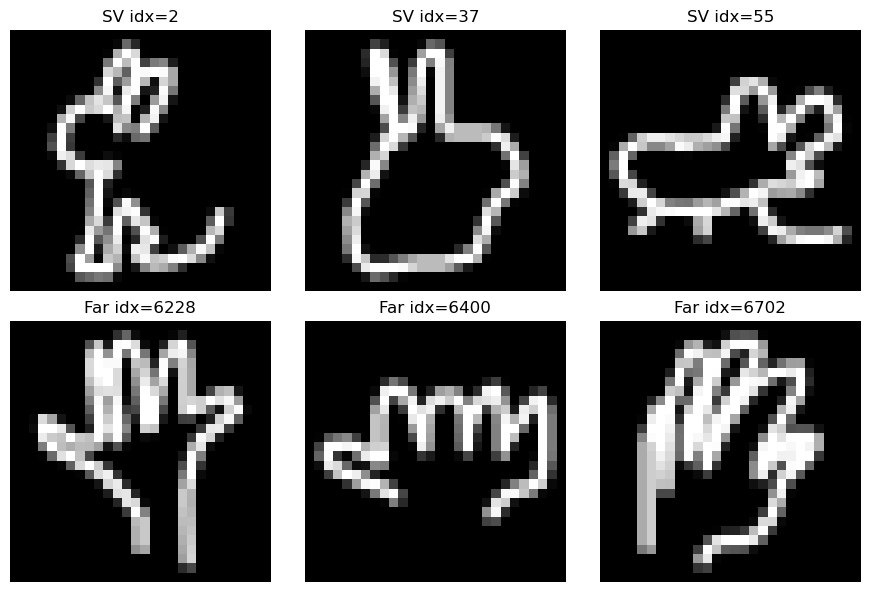

In [ ]:
pcs = PCA_from_Scratch(train_normal, dim)
train_proj = transform(train_normal, pcs)
test_proj = transform(test_normal, pcs)
clf = SVC(kernel='poly',   C=C,
                              degree=3, coef0=1, gamma='scale')

clf.fit(train_proj, train_labels.flatten())
sv_indices = clf.support_
dists    = clf.decision_function(train_proj)
abs_dists = np.abs(dists)
far_all  = np.argsort(abs_dists)[-len(sv_indices):]
dists = clf.decision_function(train_proj)          
abs_dists = np.abs(dists)

sv_idx  = sv_indices[:3]
far_idx = far_all[:3]

fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for ax, idx in zip(axes[0], sv_idx):
    ax.imshow(train_images[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f"SV idx={idx}")
for ax, idx in zip(axes[1], far_idx):
    ax.imshow(train_images[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Far idx={idx}")

plt.tight_layout()
plt.show()
